# Exploring unimodal data

This tutorial demonstrates a new approach for analyzing unimodal developmental single-cell data using Ocelli. The proposed workflow uses topic modeling for finding cohesive regions (topics) in the single-cell expression space. We treat each topic as a separate modality, which consists of features that are highly specific to this topic. Using topic-based modalities significantly reduces noise in the single-cell data.

## Pancreatic endocrinogenesis (RNA-seq)

This RNA-seq dataset consists of pancreatic developmental cells sampled from embryonic day 15.5. Endocrine cells are derived from endocrine progenitors and form four significant lineages:

- Glucagon-producing Alpha cells,
- Insulin-producing Beta cells,
- Somatostatin-producing Delta cells,
- Ghrelin-producing Epsilon cells.

Data comes from [Bastidas-Ponce, Aimée, et al. "Comprehensive single cell mRNA profiling reveals a detailed roadmap for pancreatic endocrinogenesis." Development 146.12 (2019): dev173849.](https://journals.biologists.com/dev/article/146/12/dev173849/19483/Comprehensive-single-cell-mRNA-profiling-reveals-a). It can be downloaded from [scVelo](https://scvelo.readthedocs.io/scvelo.datasets.pancreas/).

Import necessary packages.

In [1]:
import ocelli as oci
import scanpy as sc
import scvelo as scv

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

SEED = 17

### Load and preprocess the data

Load the data using scVelo.

In [2]:
adata = scv.datasets.pancreas()

adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

Filter out low-expressed genes and low-quality cells.

In [3]:
sc.pp.filter_cells(adata, min_genes=20)
scv.pp.filter_genes(adata, min_shared_cells=20)

Filtered out 22533 genes that are detected in less than 20 cells (shared).


As with the previous tutorials, the first step is the LDA topic modeling.

In [4]:
oci.pp.LDA(adata, n_components=20, verbose=1, max_iter=50, random_state=SEED)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

Training the MDM on the LDA-reduced RNA-seq count matrix would result in normal, unimodal Diffusion Maps. While such an approach is perfectly valid, LDA provides additional information - variational parameters for gene-topic distribution. These parameters can be interpreted as a pseudo count representing the number of times a gene was assigned to a topic. ``oci.pp.LDA`` saves these parameters to ``adata.varm['lda']`` as an array of shape ``(n_var, n_topics)``.

In [5]:
adata.varm['lda'].shape

(5465, 20)

Topic modeling learns cohesive groups of genes. We propose to treat them as individual modalities. ``oci.pp.modality_generation`` looks at variational parameters in ``adata.varm['lda']`` and assigns each gene to a highest-parameter topic. Grouped genes form new modalities. Note that generated modalities are not in the LDA latent space but in the single-cell expression space. You can control the number of genes in each modality - the default value is at most 100. If you set ``norm_log`` to True, new modalities are normalized and logarithmized.

In [6]:
oci.pp.modality_generation(adata, lda_weights_key='lda_weights', n_top_vars=100, norm_log=True, verbose=True)

[modality0]	Modality generated.
[modality1]	Modality generated.
[modality2]	Modality generated.
[modality3]	Modality generated.
[modality4]	Modality generated.
[modality5]	Modality generated.
[modality6]	Modality generated.
[modality7]	Modality generated.
[modality8]	Modality generated.
[modality9]	Modality generated.
[modality10]	Modality generated.
[modality11]	Modality generated.
[modality12]	Modality generated.
[modality13]	Modality generated.
[modality14]	Modality generated.
[modality15]	Modality generated.
[modality16]	Modality generated.
[modality17]	Modality generated.
[modality18]	Modality generated.
[modality19]	Modality generated.
20 topic-based modalities generated.


``oci.pp.modality_generation`` automatically saves generated modality names to ``adata.uns['modalities']``.

In [7]:
adata.uns['modalities']

['modality0',
 'modality1',
 'modality2',
 'modality3',
 'modality4',
 'modality5',
 'modality6',
 'modality7',
 'modality8',
 'modality9',
 'modality10',
 'modality11',
 'modality12',
 'modality13',
 'modality14',
 'modality15',
 'modality16',
 'modality17',
 'modality18',
 'modality19']

We suggest visualizing this dataset with additional RNA velocity information for the better reconstruction of developmental fates. Data downloaded from scVelo includes unspliced and spliced gene expression layers ready for RNA velocity estimation.

Calculate velocities on normalized and logarithmized highly variable genes. 

In [8]:
scv.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
scv.pp.filter_genes_dispersion(adata, n_top_genes=1000)
scv.pp.log1p(adata)

scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Multimodal Diffusion Maps

Modalities with normalized and logarithmized topic-specific gene counts are ready for the MDM training. We use LDA's cell-topic distributions as weights. These distributions can be interpreted as the assignment of topics to cells. In other words, a cell's MDM representation is based only on genes specific to topics assigned to a cell. The significant advantage of such an approach is that for each expression space region (topic), you utilize only relevant region-specific (topic-specific) genes. This step significantly reduces noise existing in single-cell data.

``oci.pp.modality_generation`` saves LDA-based weights to ``adata.obsm['lda_weights']``.

In [9]:
adata.obsm['lda_weights']

modality0  modality1  modality2  modality3  modality4  \
index                                                                     
AAACCTGAGAGGGATA   0.002430   0.007674   0.007712   0.102145   0.002342   
AAACCTGAGCCTTGAT   0.001912   0.278708   0.002602   0.087956   0.001166   
AAACCTGAGGCAATTA   0.003665   0.012536   0.014184   0.013503   0.002706   
AAACCTGCATCATCCC   0.001046   0.118428   0.002715   0.029078   0.001066   
AAACCTGGTAAGTGGC   0.001827   0.010498   0.011332   0.030509   0.001866   
...                     ...        ...        ...        ...        ...   
TTTGTCAAGTGACATA   0.001140   0.006241   0.021874   0.041146   0.001111   
TTTGTCAAGTGTGGCA   0.001294   0.002969   0.003524   0.102868   0.001158   
TTTGTCAGTTGTTTGG   0.002135   0.405979   0.002980   0.081686   0.001517   
TTTGTCATCGAATGCT   0.001022   0.002333   0.002794   0.117173   0.315331   
TTTGTCATCTGTTTGT   0.143304   0.006576   0.005247   0.033054   0.001594   

                  modality5  modality6  modality7  modality8  modality9  \
index                                                                     
AAACCTGAGAGGGATA   0.008317   0.001827   0.017973   0.007638   0.063900   
AAACCTGAGCCTTGAT   0.012176   0.001074   0.104506   0.012574   0.006301   
AAACCTGAGGCAATTA   0.020714   0.027890   0.077708   0.015388   0.063211   
AAACCTGCATCATCCC   0.012884   0.000936   0.110373   0.087123   0.003526   
AAACCTGGTAAGTGGC   0.085311   0.001635   0.018233   0.009816   0.182690   
...                     ...        ...        ...        ...        ...   
TTTGTCAAGTGACATA   0.009308   0.001104   0.057680   0.013975   0.166825   
TTTGTCAAGTGTGGCA   0.113681   0.001086   0.025608   0.007960   0.009393   
TTTGTCAGTTGTTTGG   0.039509   0.001331   0.144264   0.009441   0.008396   
TTTGTCATCGAATGCT   0.025995   0.044490   0.095125   0.007444   0.020210   
TTTGTCATCTGTTTGT   0.014391   0.007333   0.004904   0.011057   0.210133   

                  modality10  modality11  modality12  modality13  modality14  \
index                                                                          
AAACCTGAGAGGGATA    0.049555    0.042434    0.094664    0.024815    0.079300   
AAACCTGAGCCTTGAT    0.026456    0.004610    0.243986    0.020106    0.000990   
AAACCTGAGGCAATTA    0.071690    0.151815    0.131225    0.030949    0.011694   
AAACCTGCATCATCCC    0.058260    0.003513    0.121219    0.007089    0.000843   
AAACCTGGTAAGTGGC    0.056825    0.012112    0.048607    0.120583    0.002015   
...                      ...         ...         ...         ...         ...   
TTTGTCAAGTGACATA    0.046281    0.067421    0.092043    0.092049    0.000877   
TTTGTCAAGTGTGGCA    0.034449    0.004601    0.035406    0.106191    0.000895   
TTTGTCAGTTGTTTGG    0.067988    0.004884    0.069425    0.016991    0.001272   
TTTGTCATCGAATGCT    0.007918    0.129767    0.056801    0.009333    0.016400   
TTTGTCATCTGTTTGT    0.035173    0.347378    0.009384    0.035745    0.041918   

                  modality15  modality16  modality17  modality18  modality19  
index                                                                         
AAACCTGAGAGGGATA    0.009830    0.371567    0.043714    0.020644    0.041521  
AAACCTGAGCCTTGAT    0.132102    0.003261    0.005555    0.032054    0.021906  
AAACCTGAGGCAATTA    0.034146    0.243392    0.008848    0.016192    0.048543  
AAACCTGCATCATCCC    0.418786    0.002353    0.003590    0.012426    0.004745  
AAACCTGGTAAGTGGC    0.012569    0.036090    0.297624    0.054869    0.004990  
...                      ...         ...         ...         ...         ...  
TTTGTCAAGTGACATA    0.008964    0.200480    0.118638    0.042896    0.009948  
TTTGTCAAGTGTGGCA    0.118450    0.004743    0.262046    0.156797    0.006881  
TTTGTCAGTTGTTTGG    0.090794    0.003418    0.006730    0.022281    0.018983  
TTTGTCATCGAATGCT    0.022803    0.005755    0.028691    0.008228    0.082386  
TTTGTCATCTGTTTGT    0.016507    0.004828    0.009769    0.017603    0.044101 

Calculate the MDM representation.

In [10]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.MDM(adata, weights_key='lda_weights', n_components=25, random_state=SEED, verbose=True)

[modality0]	20 nearest neighbors calculated.
[modality1]	20 nearest neighbors calculated.
[modality2]	20 nearest neighbors calculated.
[modality3]	20 nearest neighbors calculated.
[modality4]	20 nearest neighbors calculated.
[modality5]	20 nearest neighbors calculated.
[modality6]	20 nearest neighbors calculated.
[modality7]	20 nearest neighbors calculated.
[modality8]	20 nearest neighbors calculated.
[modality9]	20 nearest neighbors calculated.
[modality10]	20 nearest neighbors calculated.
[modality11]	20 nearest neighbors calculated.
[modality12]	20 nearest neighbors calculated.
[modality13]	20 nearest neighbors calculated.
[modality14]	20 nearest neighbors calculated.
[modality15]	20 nearest neighbors calculated.
[modality16]	20 nearest neighbors calculated.
[modality17]	20 nearest neighbors calculated.
[modality18]	20 nearest neighbors calculated.
[modality19]	20 nearest neighbors calculated.


2022-11-02 21:37:15,701	INFO worker.py:1518 -- Started a local Ray instance.


[modality0]	Unimodal Markov chain calculated.
[modality1]	Unimodal Markov chain calculated.
[modality2]	Unimodal Markov chain calculated.
[modality3]	Unimodal Markov chain calculated.
[modality4]	Unimodal Markov chain calculated.
[modality5]	Unimodal Markov chain calculated.
[modality6]	Unimodal Markov chain calculated.
[modality7]	Unimodal Markov chain calculated.
[modality8]	Unimodal Markov chain calculated.
[modality9]	Unimodal Markov chain calculated.
[modality10]	Unimodal Markov chain calculated.
[modality11]	Unimodal Markov chain calculated.
[modality12]	Unimodal Markov chain calculated.
[modality13]	Unimodal Markov chain calculated.
[modality14]	Unimodal Markov chain calculated.
[modality15]	Unimodal Markov chain calculated.
[modality16]	Unimodal Markov chain calculated.
[modality17]	Unimodal Markov chain calculated.
[modality18]	Unimodal Markov chain calculated.
[modality19]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
25 Mu

Calculate the ForceAtlas2 representation of the MDM embedding's RNA velocity-based graph.

In [11]:
oci.pp.neighbors(adata, modalities=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.velocity_graph(adata, n_edges=20, neighbors_key='X_mdm', verbose=True)

oci.tl.FA2(adata, n_components=2, random_state=SEED, output_key='X_fa2')

[X_mdm]	100 nearest neighbors calculated.
RNA velocity-based graph constructed.


Nov 02, 2022 9:37:39 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Nov 02, 2022 9:37:39 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 3,696 (3,696 added)
Nov 02, 2022 9:37:39 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 73,920 (70,765 added)


*************************25%
*************************50%
*************************75%
*************************100%
Time = 21.153s


Plot the 2D embedding with the annotations prepared by the dataset authors (stored in ``adata.obs['clusters']``). 

(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

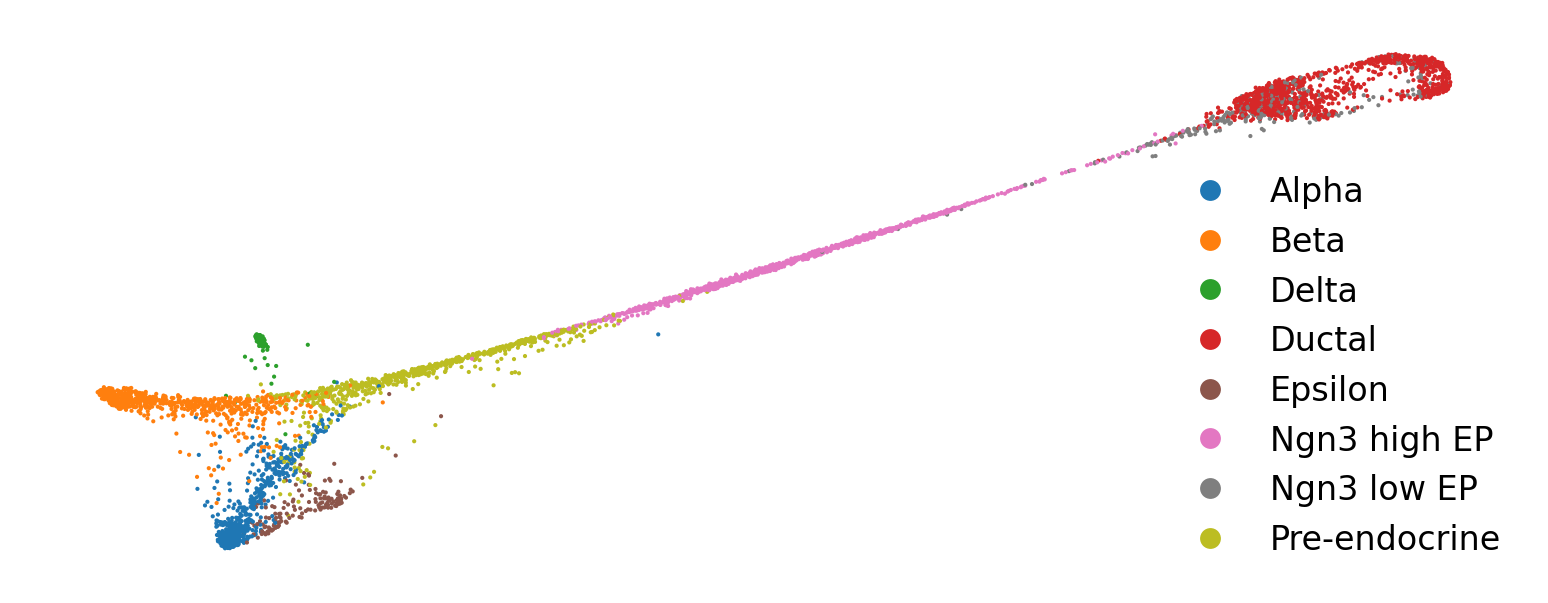

In [12]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='clusters', cmap='tab10', marker_size=1, fontsize=8)

Each LDA topic relates to a different region of the single-cell expression space. You can investigate these regions by plotting topic activity (cell-topic distributions).

(<Figure size 1920x1440 with 41 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>],
        [<AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>,
         <AxesSubplot:title={'center':'5'}>],
        [<AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'8'}>],
        [<AxesSubplot:title={'center':'9'}>,
         <AxesSubplot:title={'center':'10'}>,
         <AxesSubplot:title={'center':'11'}>],
        [<AxesSubplot:title={'center':'12'}>,
         <AxesSubplot:title={'center':'13'}>,
         <AxesSubplot:title={'center':'14'}>],
        [<AxesSubplot:title={'center':'15'}>,
         <AxesSubplot:title={'center':'16'}>,
         <AxesSubplot:title={'center':'17'}>],
        [<AxesSubplot:title={'center':'18'}>,
         <AxesSubplot:title={'center':'19'}>, <AxesSubplot:>]],
       dtype=object))

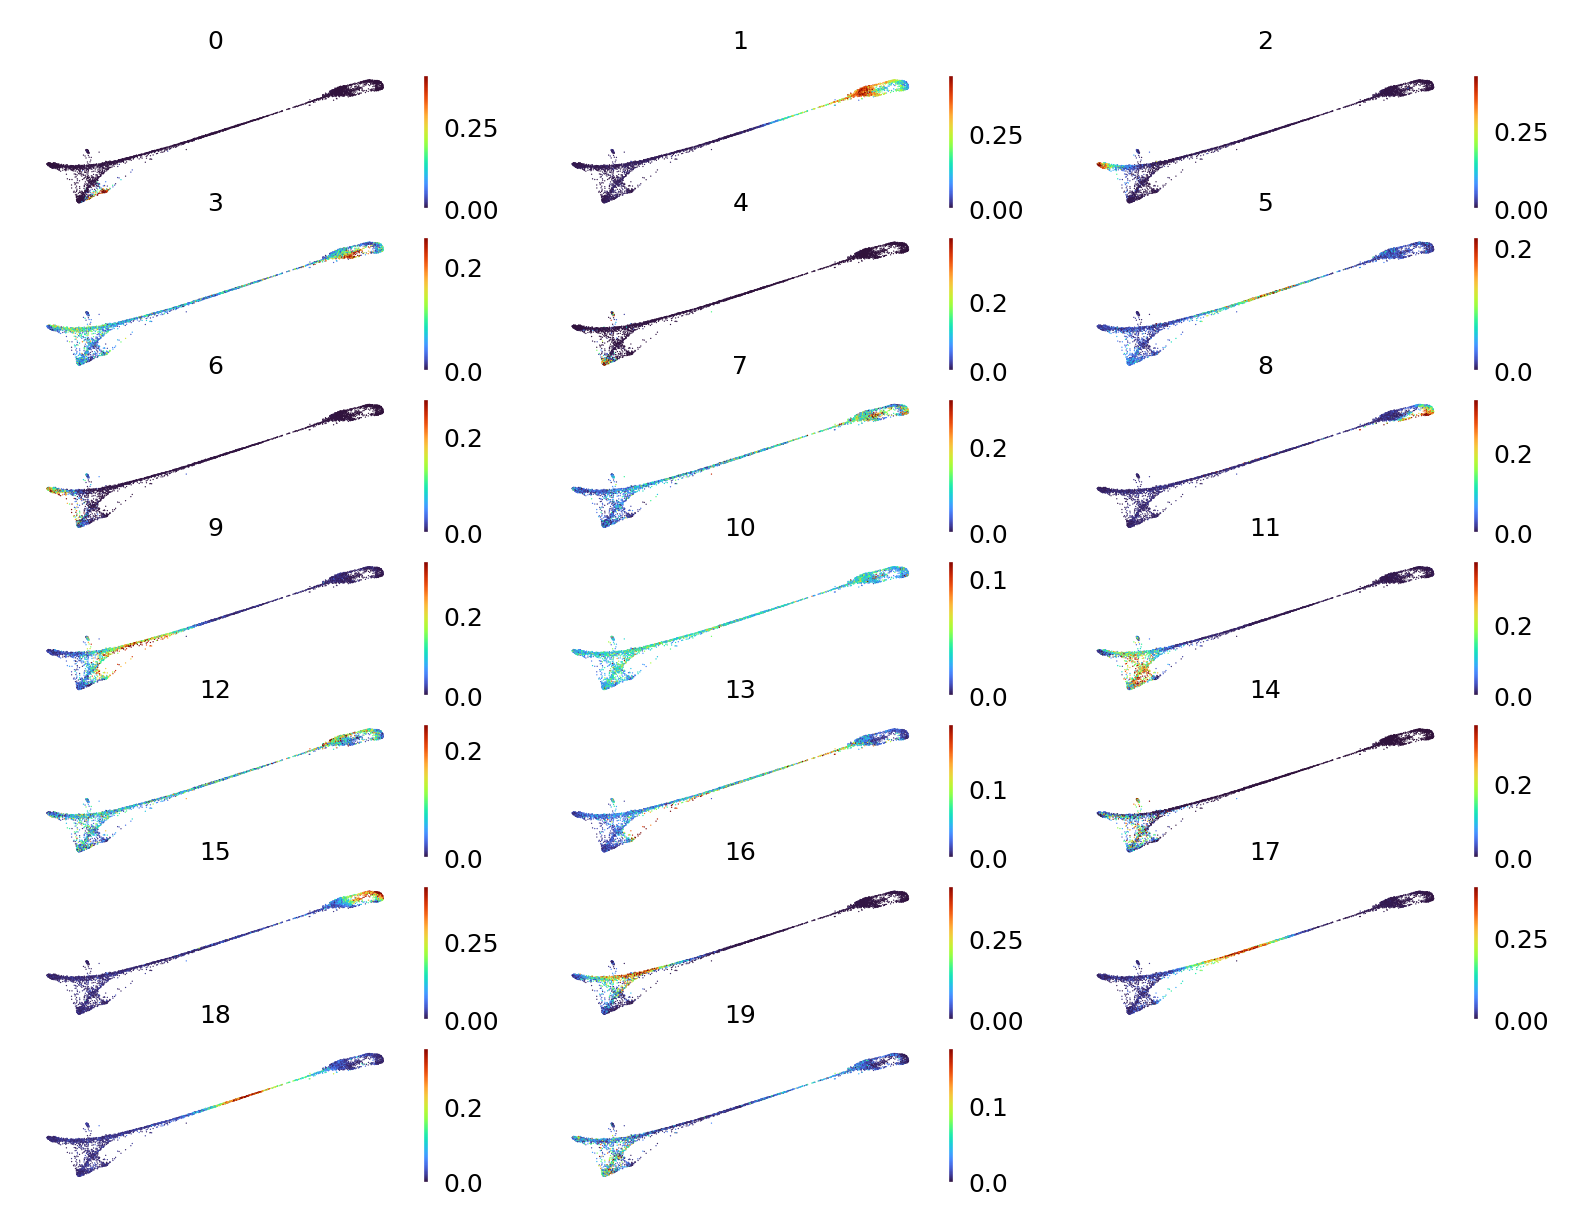

In [13]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='lda', cmap='turbo', marker_size=0.1, vmin=0, max_columns=3)

Two significant regions split the developmental process: proliferative Ductal cells, and endocrine lineages.

### Cell cycle reconstruction

Firstly, investigate the cell cycle of proliferative Ductal cells.

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_fa2', embedded velocity vectors (adata.obsm)


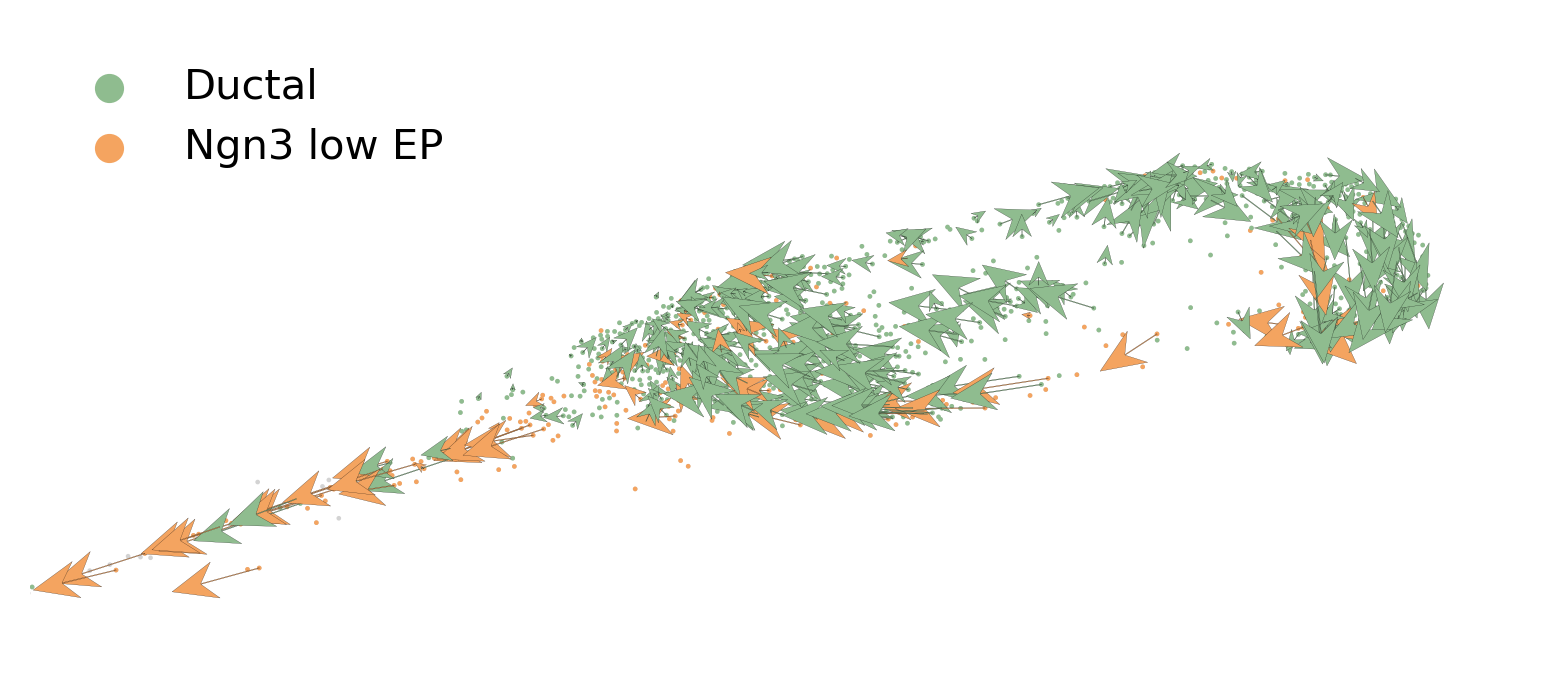

In [14]:
fig, ax = plt.subplots()
scv.pl.velocity_embedding(adata, basis='fa2', arrow_length=5, arrow_size=5, alpha=1, 
                          title='', density=0.3, size=5, legend_loc='best',
                          linewidth=0.05, show=False, ax=ax, groups=['Ductal', 'Ngn3 low EP'],
                          xlim=[8000, 14000], ylim=[2500, 5000])
ax.set_aspect('equal')

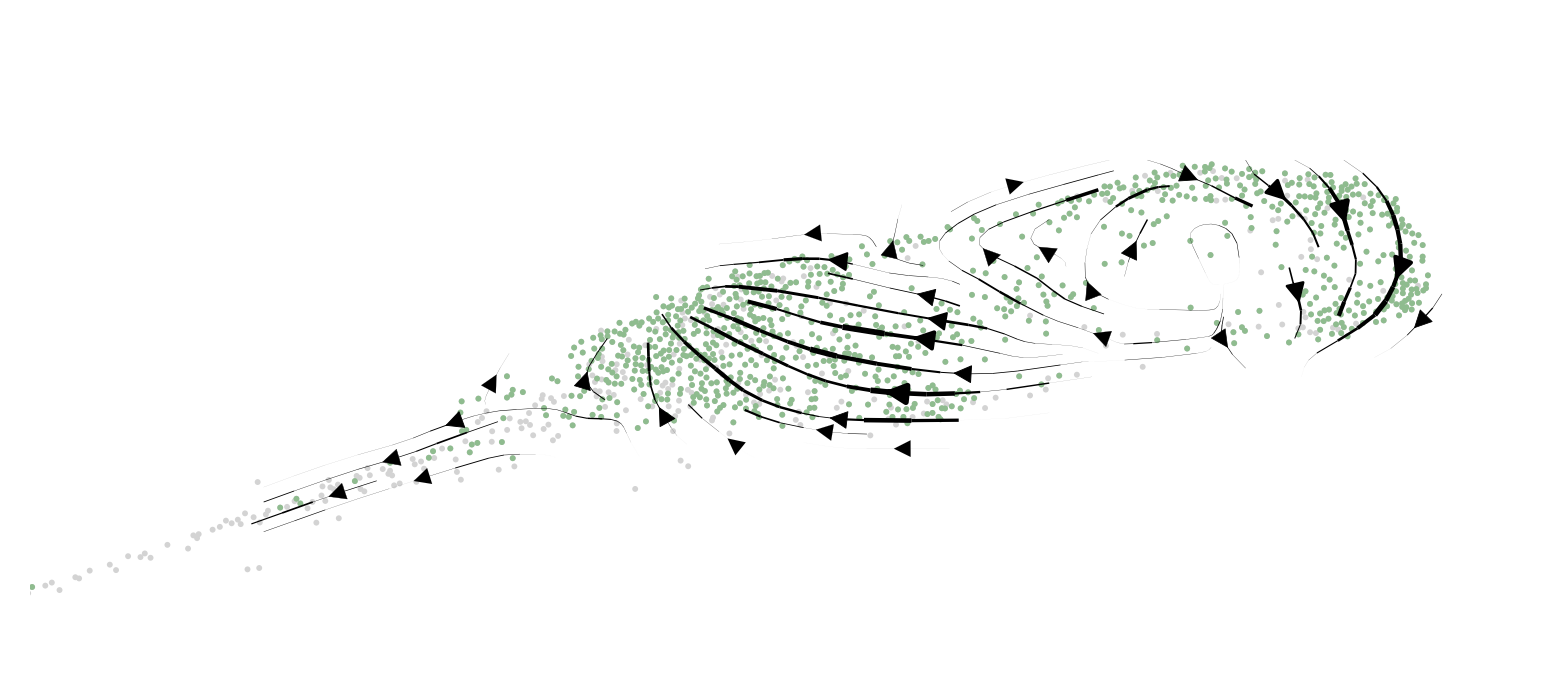

In [15]:
fig, ax = plt.subplots()

scv.pl.velocity_embedding_stream(adata, basis='fa2', alpha=1, title='', density=1, 
                                 linewidth=1, size=8, legend_loc='none', groups=['Ductal'], show=False, ax=ax, 
                                 xlim=[8000, 14000], ylim=[2500, 5000])

ax.set_aspect('equal')

You can validate the velocity stream by plotting scores for:

- S (DNA replication) cell cycle phase,
- combined G2 (preparation for mitosis) and M (cell division) cell cycle phases.

Arrows should go from high S-scoring cells towards high G2M-scoring cells.

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


Text(0.5, 1.0, 'Combined G2 and M phases\nPreparation for mitosis and cell division')

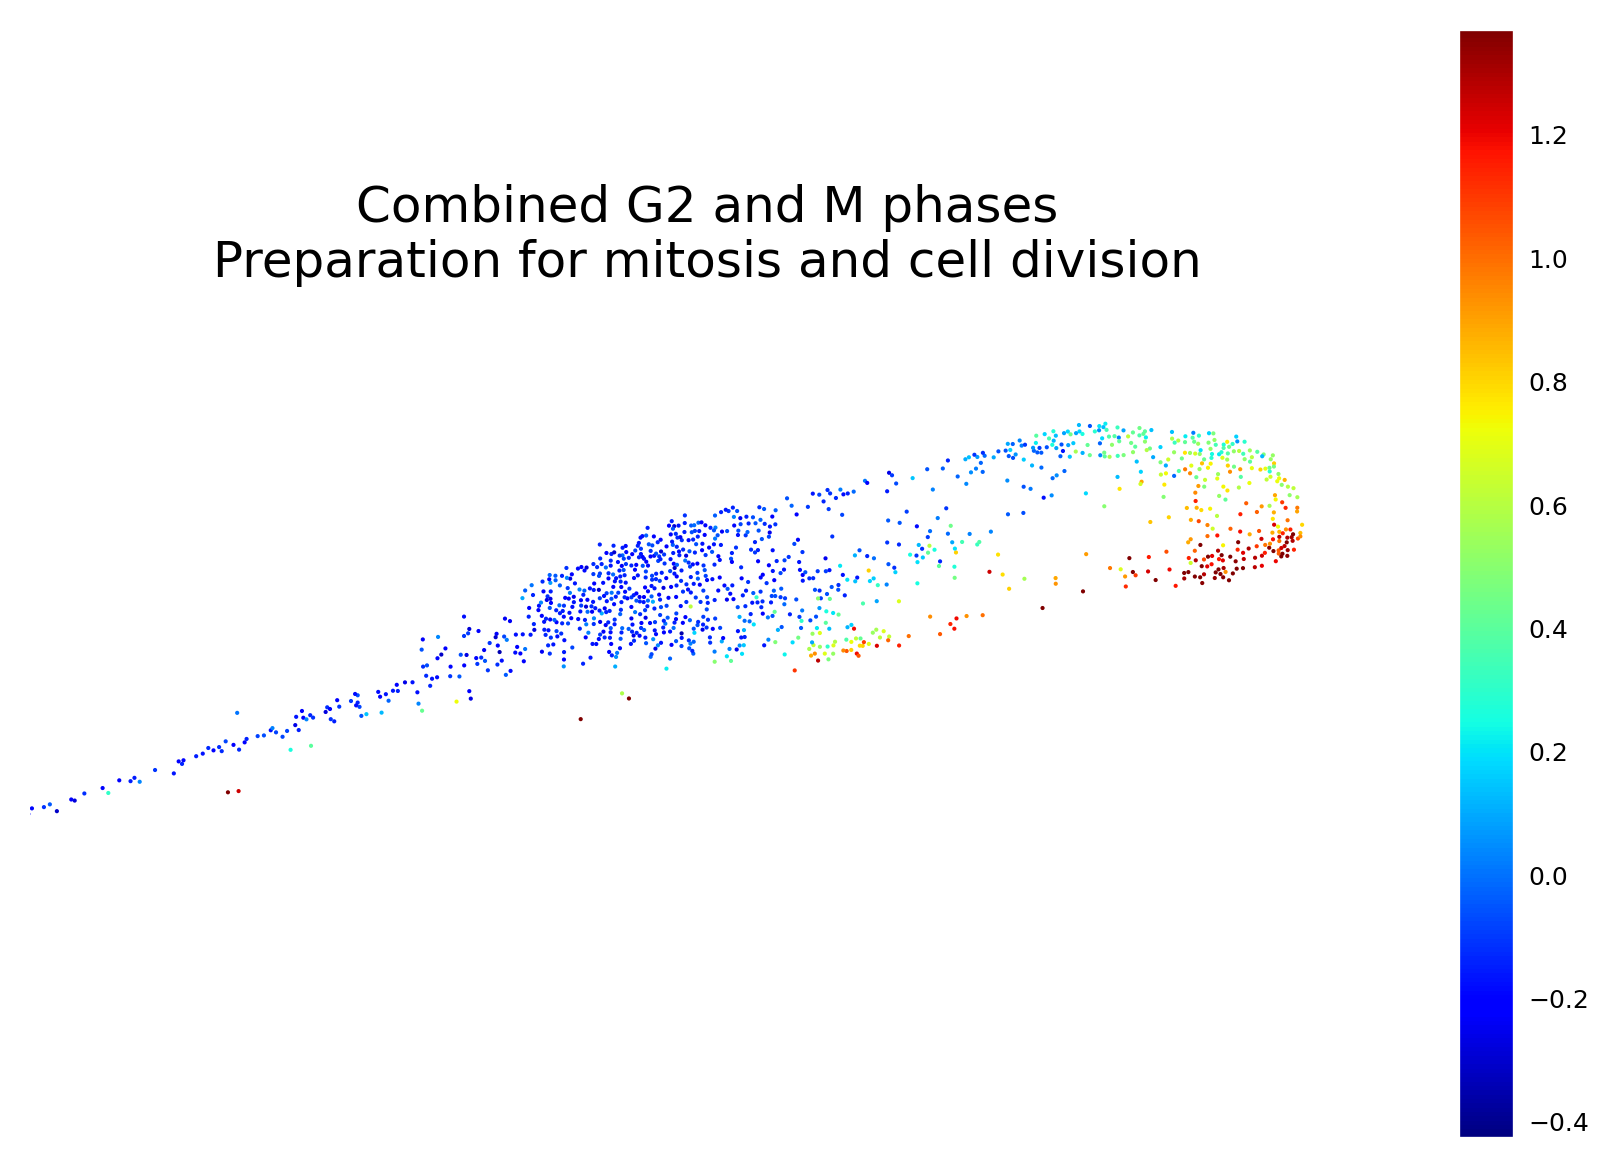

In [16]:
scv.tl.score_genes_cell_cycle(adata)

fig, ax = oci.pl.scatter(adata, x_key='X_fa2', color_key='S_score', cmap='jet', marker_size=1)
ax.set_xlim([8000, 14000])
ax.set_ylim([2500, 5000])
ax.set_title('Phase S\nDNA replication')


fig, ax = oci.pl.scatter(adata, x_key='X_fa2', color_key='G2M_score', cmap='jet', marker_size=1)
ax.set_xlim([8000, 14000])
ax.set_ylim([2500, 5000])
ax.set_title('Combined G2 and M phases\nPreparation for mitosis and cell division')

### Development of endocrine cells

The development of four endocrine fates: Alpha, Beta, Delta, and Epsilon was studied [here](https://www.nature.com/articles/s41422-021-00486-w). MDM manages to reconstruct all four lineages. 

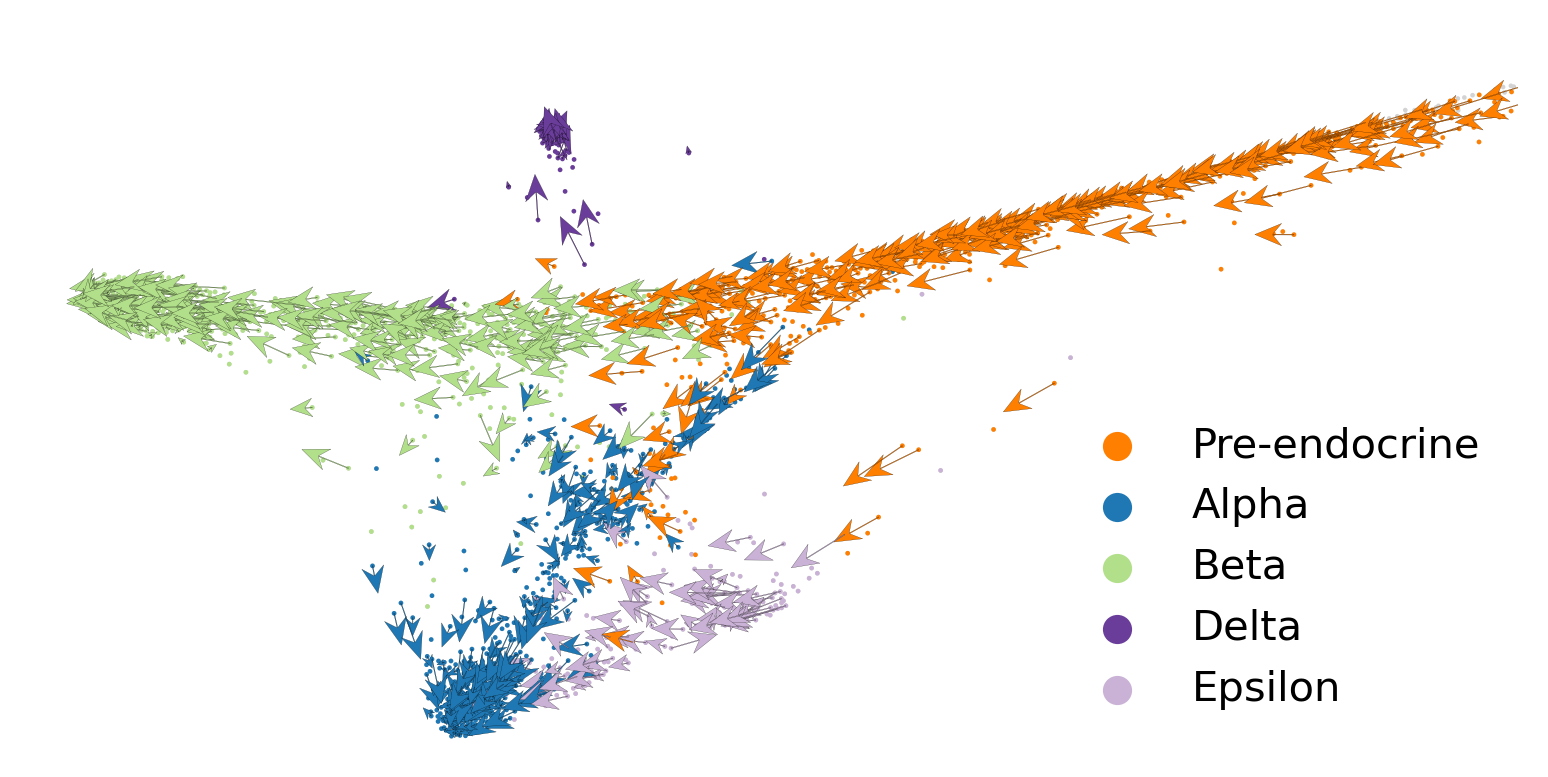

In [17]:
celltypes = ['Pre-endocrine', 'Alpha', 'Beta', 'Delta', 'Epsilon']

fig, ax = plt.subplots()
scv.pl.velocity_embedding(adata, basis='fa2', arrow_length=5, arrow_size=3, alpha=1, 
                          title='', density=0.4, size=5, legend_loc='best',
                          linewidth=0.05, show=False, ax=ax, groups=celltypes, 
                          xlim=[-8300, 0], ylim=[-3500, 500])
ax.set_aspect('equal')

## iPSCs reprogramming (RNA-seq)

In the second half of the tutorial, you will analyze a more complex biological system of cellular reprogramming. Cell reprogramming aims to reprogram a cell to a different cell type. It involves a conversion of the cell to an induced pluripotent stem cell (iPSC) before differentiation into one of many diverse cell types.

The data we will work on comes from [Schiebinger, Geoffrey, et al. "Optimal-transport analysis of single-cell gene expression identifies developmental trajectories in reprogramming." Cell 176.4 (2019): 928-943.](https://www.sciencedirect.com/science/article/pii/S009286741930039X). The authors obtained Mouse Embryonic Fibroblasts (MEFs) from a single female embryo. They plated MEFs in serum, added Dox on day 0, withdrew Dox on day 8, and transferred cells to either serum-free N2B27 2i medium or maintained them in serum. Hence experiment can be split into Phase 1 (Dox) and Phase 2 (two separate conditions: 2i, serum). Phase 2 lasted till day 18.

Below, we will explore Phase 2 with serum condition. Firstly, load the necessary packages.

In [18]:
import anndata
from os.path import join
import pandas as pd
import scanpy as sc
import ocelli as oci
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

SEED = 17

# path to data
data_folder = '../../../../experiments/reprogramming/data'

### Load and preprocess the data

During data preparation, we ran the [Velocyto](http://velocyto.org) on [raw ``bam`` files](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115943). Then, we concatenated the resulting ``loom`` files into a single ``h5ad`` file and calculated doublet scores using [scrublet](https://github.com/swolock/scrublet). Let's load the resulting file.

In [2]:
%%time

adata = anndata.read_h5ad(join(data_folder, 'reprogramming_doublet.h5ad'))

adata

CPU times: user 3.27 s, sys: 11.6 s, total: 14.8 s
Wall time: 3min 14s


AnnData object with n_obs × n_vars = 251203 × 27998
    obs: 'origin', 'barcode', 'velocyto_barcode', 'doublet_score', 'predicted_doublet'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

The whole dataset consists  of 251,203 cells and standard 10X 27998 genes.

For esthetic purposes, we clean up ``adata.obs``.

In [3]:
df_obs = pd.DataFrame(index=list(adata.obs.index))
df_obs['timestamp'] = [el.split('_')[0][1:] for el in adata.obs['origin']]
df_obs['origin'] = [el.split('_')[1] for el in adata.obs['origin']]
df_obs['doublet_score'] = list(adata.obs['doublet_score'])

adata.obs = df_obs

adata.obs

timestamp origin  doublet_score
D0.5_Dox_C2_AACGTTGAGTGGACGT-1          0.5    Dox       0.109677
D0.5_Dox_C2_AACTGGTGTAGAGTGC-1          0.5    Dox       0.179331
D0.5_Dox_C2_AAATGCCTCTCAAGTG-1          0.5    Dox       0.192308
D0.5_Dox_C2_AACTCCCAGTCAAGCG-1          0.5    Dox       0.103734
D0.5_Dox_C2_AACTTTCCATGTCGAT-1          0.5    Dox       0.286344
...                                     ...    ...            ...
DiPSC_serum_C2_TTTATGCCAGCTGTAT-1      iPSC  serum       0.126516
DiPSC_serum_C2_TTTCCTCCAAGAGTCG-1      iPSC  serum       0.121212
DiPSC_serum_C2_TTTCCTCGTTGGTTTG-1      iPSC  serum       0.121212
DiPSC_serum_C2_TTTGTCATCTTCGGTC-1      iPSC  serum       0.026253
DiPSC_serum_C2_TTTACTGTCACGATGT-1      iPSC  serum       0.215385

[251203 rows x 3 columns]

And load 10X gene list for ``adata.var``.

In [4]:
df_var = pd.read_csv(join(data_folder, '10X-vars.csv'), names=['gene'], index_col='gene', header=0)

adata.var = df_var

adata.var

Empty DataFrame
Columns: []
Index: [Xkr4, Gm37381, Rp1, Rp1-1, Sox17, Gm37323, Mrpl15, Rgs20, Npbwr1, 4732440D04Rik, Gm26901, Sntg1, Gm29520, Mybl1, Vcpip1, Snhg6, Tcf24, Ppp1r42, Cops5, Arfgef1, Cpa6, Gm29663, Slco5a1, Prdm14, Ncoa2, Tram1, Lactb2, Eya1, Msc, Trpa1, Sbspon, 4930444P10Rik, Rpl7, Stau2, Ube2w, Tceb1, Jph1, Gm28154, Gm16070, Gm28153, Crisp4, Defb18, Defb41, Gm15825, Pkhd1, Il17f, Mcm3, 6720483E21Rik, Tram2, Gm28836, Kcnq5, Rims1, 4933415F23Rik, Ogfrl1, Smap1, Sdhaf4, Fam135a, Col19a1, Gm28237, Gm29414, Adgrb3, 4931408C20Rik, Gm597, Gm9898, Phf3, Ptp4a1, Gm29669, 4931428L18Rik, Gm5415, Gm37591, Prim2, Bag2, Zfp451, Bend6, Gm37958, Gm37233, Ccdc115, Gm28306, 4930568A12Rik, Prss40, 1700101I19Rik, Gm38336, Fam168b, Gm37068, Gm37146, Gm33222, Gm37335, Uggt1, Neurl3, Kansl3, Lman2l, Gm38033, Ankrd23, Gm43543, Ankrd39, Sema4c, Fam178b, Actr1b, Gm33533, Tmem131, ...]

[27998 rows x 0 columns]

Remove cells with 2i condition.

In [5]:
adata = adata[adata.obs['origin'].isin(['Dox', 'serum']), :]

Plot a histogram of doublet scores. We selected 0.3 as a good doublet threshold. Filter out all cells above this threshold.

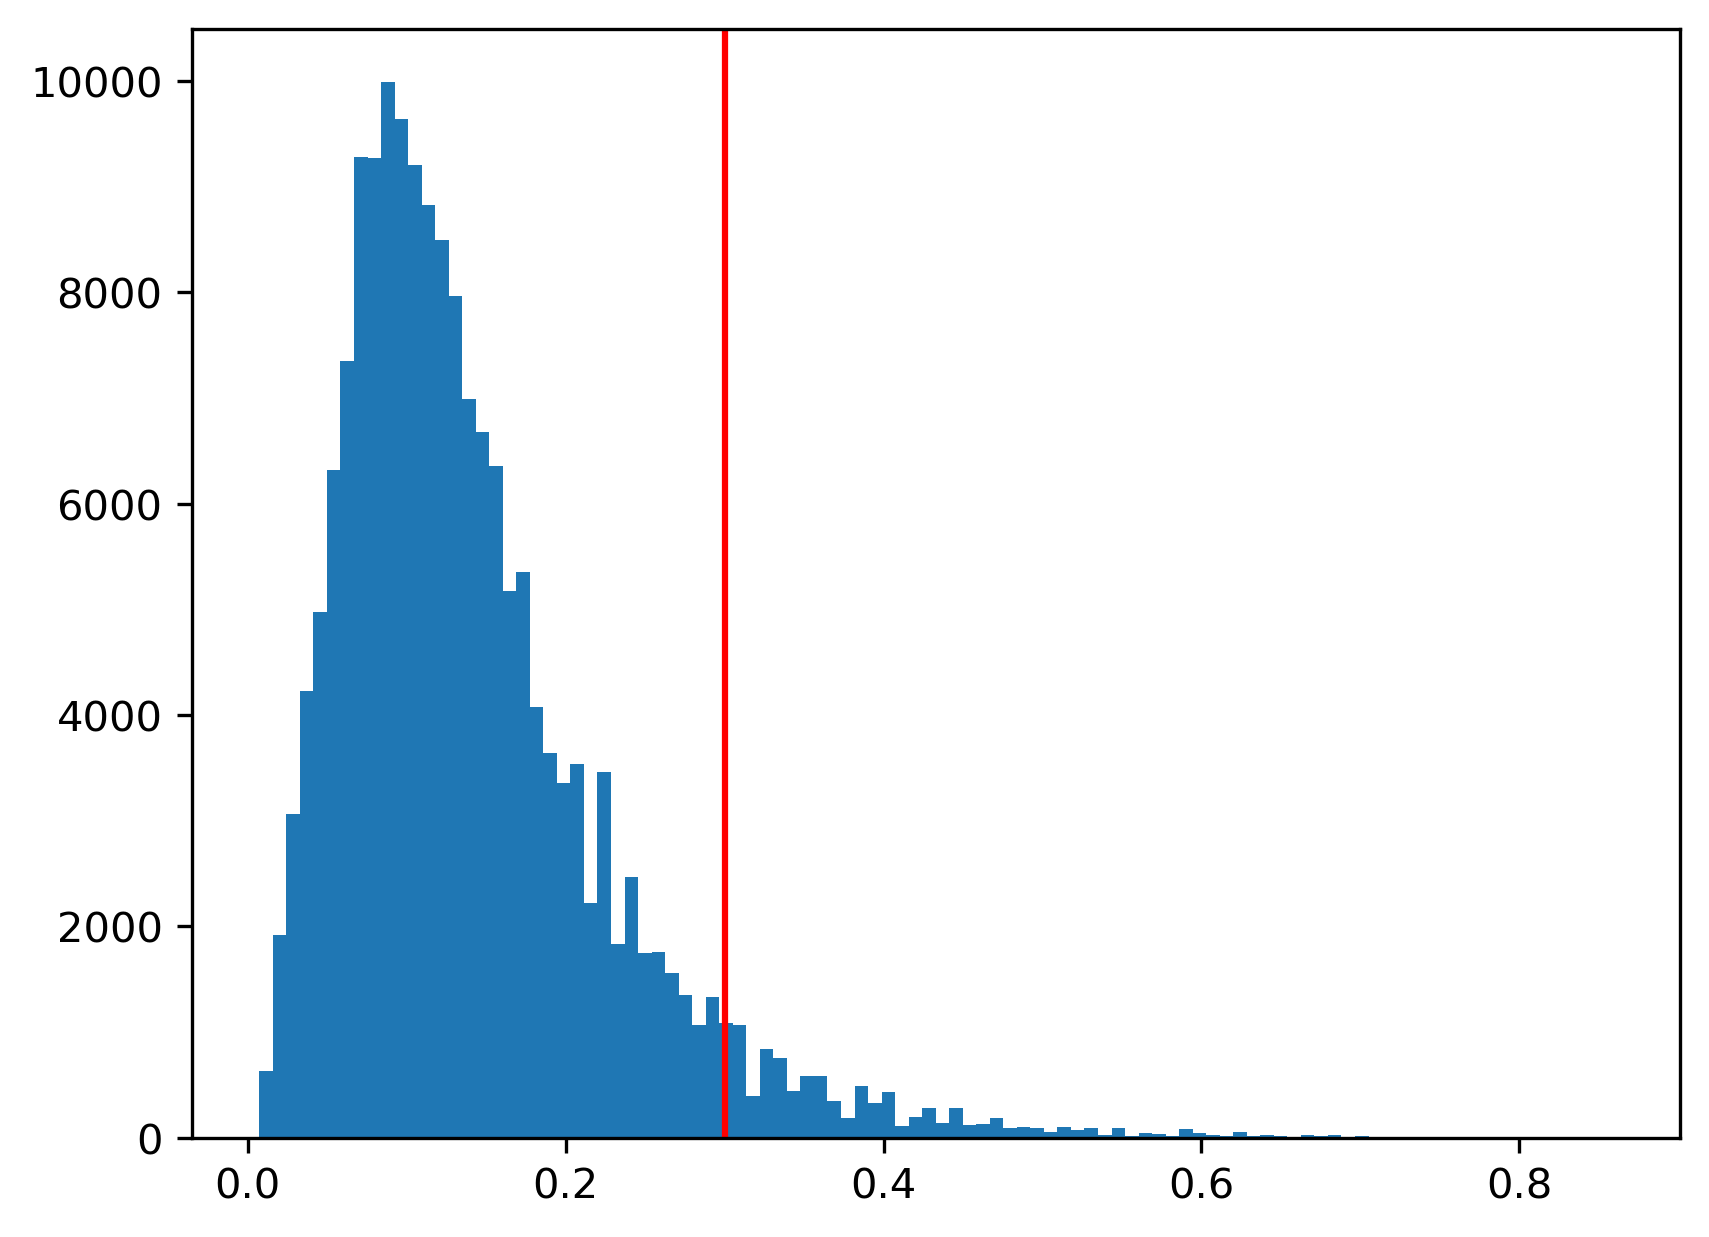

In [6]:
fig, ax = plt.subplots()
ax.hist(adata.obs['doublet_score'], 100)
ax.axvline(0.3, c='red')

adata = adata[adata.obs['doublet_score'] < 0.3]

Filter out all cells beyond days 8-18 of the experiment.

In [7]:
filtered_timestamps = ['8', '8.25', '8.5', '8.75', '9', '9.5',  
                       '10', '10.5', '11', '11.5', '12', '12.5',
                       '13', '13.5', '14', '14.5', '15', '15.5',
                       '16', '16.5', '17', '17.5', '18']

adata = adata[adata.obs['timestamp'].isin(filtered_timestamps), :]

adata.obs['timestamp_float'] = [float(t) for t in adata.obs['timestamp']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


Preprocess the count matrix as the authors:

- Remove cells with less than 2000 UMIs,
- Remove genes expressed in less than 50 cells,
- If cell's UMI count is greater than 15,000, donwsample it to 15,000 UMIs.

In [8]:
sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.downsample_counts(adata, counts_per_cell=15000, random_state=SEED)

Above steps result in 68703 cells and 16817 genes.

In [9]:
adata

AnnData object with n_obs × n_vars = 68703 × 16817
    obs: 'timestamp', 'origin', 'doublet_score', 'timestamp_float', 'n_counts'
    var: 'n_cells'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

Generate topic-based modalities.

In [13]:
oci.pp.LDA(adata, n_components=20, output_key='lda', verbose=1, max_iter=30, random_state=SEED)
oci.pp.modality_generation(adata, topic_key='lda', norm_log=True, verbose=True)
adata.X = csr_matrix(([], ([], [])), shape=adata.shape)

### Waddington Optimal Transport

Ocelli can use cellular transition probabilities calculated using any algorithm. Here, we use [Waddington Optimal Transport](https://www.sciencedirect.com/science/article/pii/S009286741930039X) precomputed transitions, which you can download [here](https://broadinstitute.github.io/wot/tutorial/) from the transport maps tutorial. The tutorial contains ``h5ad`` files with transitions between consecutive timestamps. In the code below we combine all transitions into a single ``csr_matrix`` and save it as ``adata.uns['optimal_transport']``.

In [14]:
import numpy as np
from scipy.sparse import coo_matrix
from tqdm import tqdm

adata.layers = {}

paths = ['serum_8.0_8.25.h5ad', 'serum_8.25_8.5.h5ad',  'serum_8.5_8.75.h5ad', 
         'serum_8.75_9.0.h5ad', 'serum_9.0_9.5.h5ad', 'serum_9.5_10.0.h5ad', 
         'serum_10.0_10.5.h5ad', 'serum_10.5_11.0.h5ad', 'serum_11.0_11.5.h5ad', 
         'serum_11.5_12.0.h5ad', 'serum_12.0_12.5.h5ad', 'serum_12.5_13.0.h5ad', 
         'serum_13.0_13.5.h5ad', 'serum_13.5_14.0.h5ad', 'serum_14.0_14.5.h5ad', 
         'serum_14.5_15.0.h5ad', 'serum_15.0_15.5.h5ad', 'serum_15.5_16.0.h5ad', 
         'serum_16.0_16.5.h5ad', 'serum_16.5_17.0.h5ad', 'serum_17.0_17.5.h5ad', 
         'serum_17.5_18.0.h5ad']

def filter_cells(adata, x):
    obs_in, var_in = list(), list()
    
    for el in adata.obs.index:
        if el in x.obs.index:
            obs_in.append(el)
    for el in adata.obs.index:
        if el in x.var.index:
            var_in.append(el)
            
    return x[obs_in, var_in]
        
barcode_map = dict()
for i, barcode in enumerate(adata.obs.index):
    barcode_map[barcode] = i
    
M = coo_matrix(([], ([], [])), shape=(adata.shape[0], adata.shape[0])).tocsr()
    
for path in tqdm(paths):
    x = anndata.read_h5ad(join(data_folder, 'tmaps/{}'.format(path)))    
    x = filter_cells(adata, x)
    
    obs = [barcode_map[el] for el in x.obs.index]
    var = [barcode_map[el] for el in x.var.index]
    
    M[np.ix_(obs, var)] = csr_matrix(x.X)

adata.uns['optimal_transport'] = M

  0%|          | 0/22 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|██████████| 22/22 [02:02<00:00,  5.58s/it]


### Multimodal Diffusion Maps

Calculate the Multimodal Diffusion Maps components.

In [20]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.MDM(adata, weights_key='lda', n_components=20, random_state=SEED, verbose=True, save_mmc=True)

2022-10-17 14:37:51,582	INFO worker.py:1518 -- Started a local Ray instance.


[modality0] Unimodal Markov chain calculated
[modality1] Unimodal Markov chain calculated
[modality2] Unimodal Markov chain calculated
[modality3] Unimodal Markov chain calculated
[modality4] Unimodal Markov chain calculated
[modality5] Unimodal Markov chain calculated
[modality6] Unimodal Markov chain calculated
[modality7] Unimodal Markov chain calculated
[modality8] Unimodal Markov chain calculated
[modality9] Unimodal Markov chain calculated
[modality10] Unimodal Markov chain calculated
[modality11] Unimodal Markov chain calculated
[modality12] Unimodal Markov chain calculated
[modality13] Unimodal Markov chain calculated
[modality14] Unimodal Markov chain calculated
[modality15] Unimodal Markov chain calculated
[modality16] Unimodal Markov chain calculated
[modality17] Unimodal Markov chain calculated
[modality18] Unimodal Markov chain calculated
[modality19] Unimodal Markov chain calculated
Multimodal Markov chain calculated
Eigendecomposition finished.
20 Multimodal Diffusion Ma

And generate a 3D ForceAtlas2 representation. ``oci.tl.timestamp_graph`` produces a similar to ``oci.tl.velocity_graph`` MDM- and velocity-based graph, but uses additional information from timestamps. You can find details in the API.

In [ ]:
oci.pp.neighbors(adata, modalities=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.timestamp_graph(adata, transitions_key='optimal_transport', 
                       timestamps_key='timestamp_float', n_edges=10,
                       neighbors_key='X_mdm', verbose=True)
oci.tl.FA2(adata, n_components=3, n_iter=15000, random_state=SEED, output_key='X_fa2')

23it [00:59,  2.58s/it]


Timestamp-based graph constructed.


Oct 17, 2022 2:42:50 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Oct 17, 2022 2:42:52 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 68,703 (68,703 added)
Oct 17, 2022 2:42:52 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 687,030 (607,465 added)


*

************************25%
*************************50%
*************************75%
*********************

You can create an interactive ``html`` file with a 3D scatter plot.

In [18]:
#fig = oci.pl.scatter(adata, x_key='X_fa2', color_key='timestamp_float', marker_size=1, static=False)
#fig.write_html(path)

However, here, we can only show you 2D plots. Select the best 2D perspective.

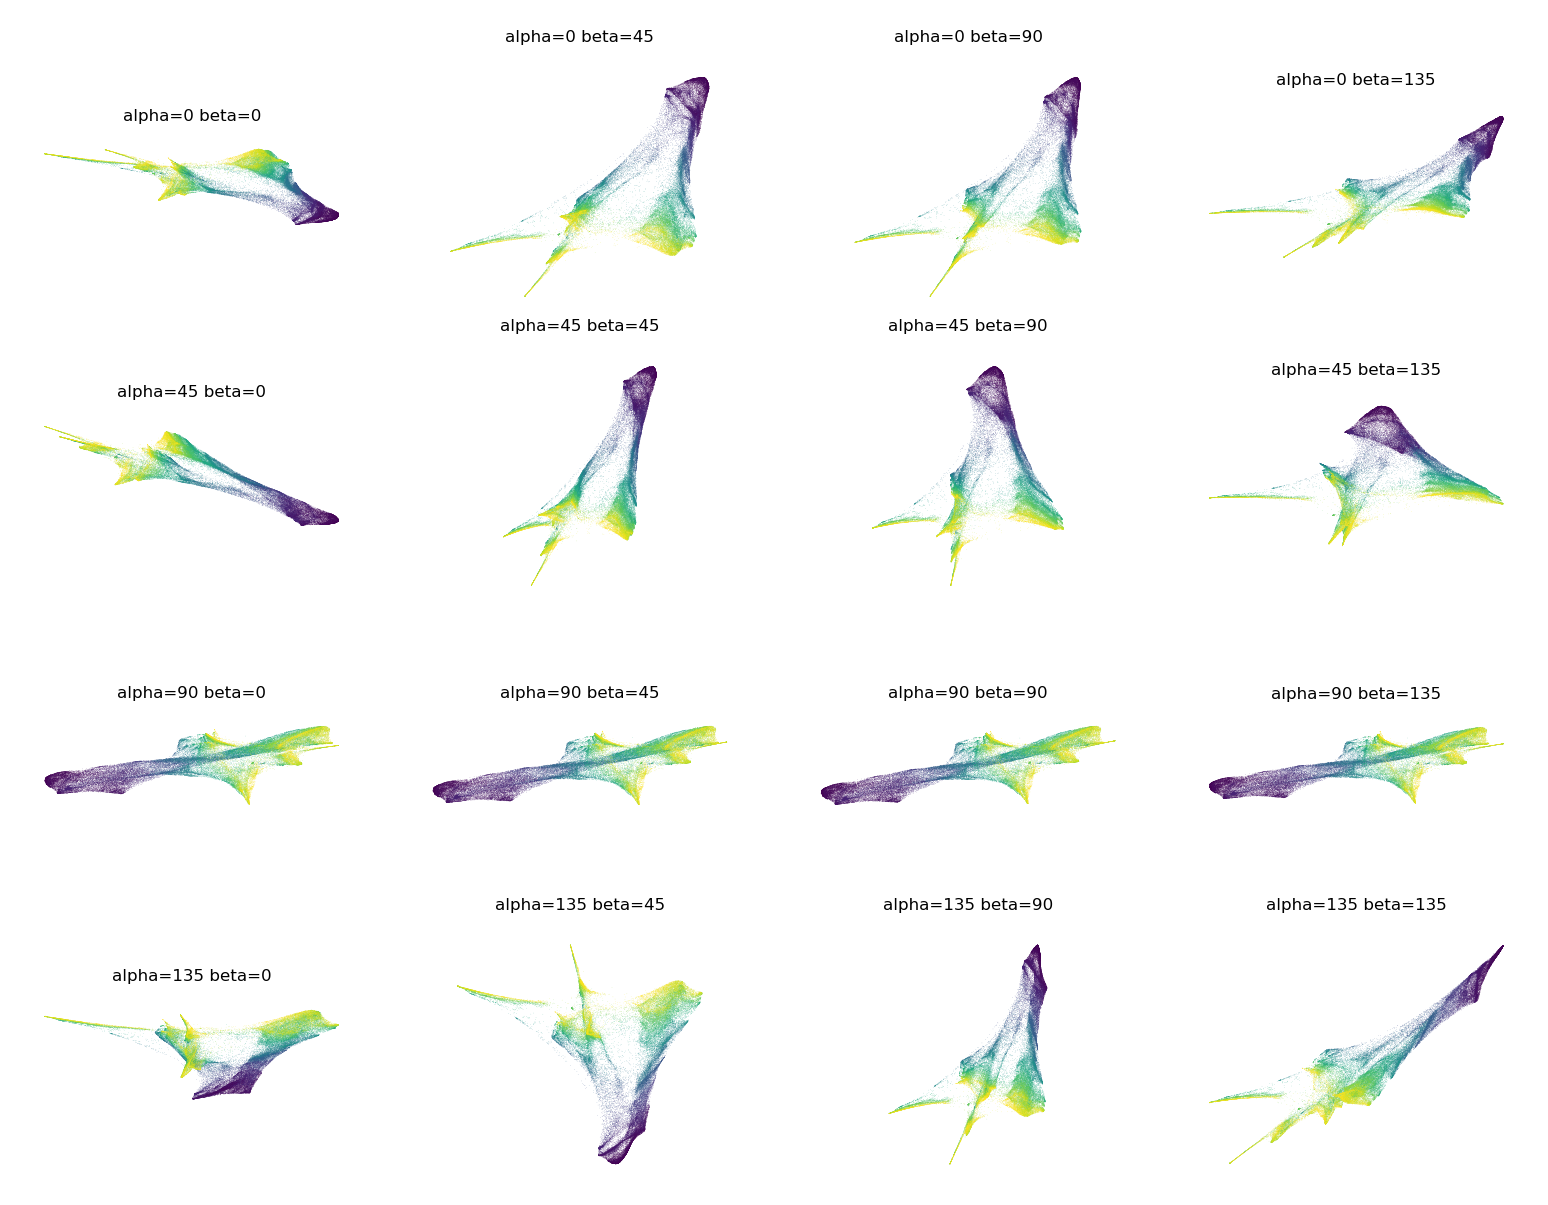

In [19]:
alphas, betas = [0, 45, 90, 135], [0, 45, 90, 135]

fig, ax = plt.subplots(len(alphas), len(betas))

for i, a in enumerate(alphas):
    for j, b in enumerate(betas):
        oci.tl.project_2d(adata, x3d_key='X_fa2', output_key='X_proj', alpha=a, beta=b, random_state=SEED)
        ax[i][j].scatter(x=adata.obsm['X_proj'][:, 0],
                         y=adata.obsm['X_proj'][:, 1], 
                         edgecolor='none', s=0.01, 
                         c=list(adata.obs['timestamp_float']))
        ax[i][j].set_aspect('equal')
        ax[i][j].axis('off')
        ax[i][j].set_title('alpha={} beta={}'.format(a, b), fontsize=4)

(<Figure size 1920x1440 with 2 Axes>, <AxesSubplot:>)

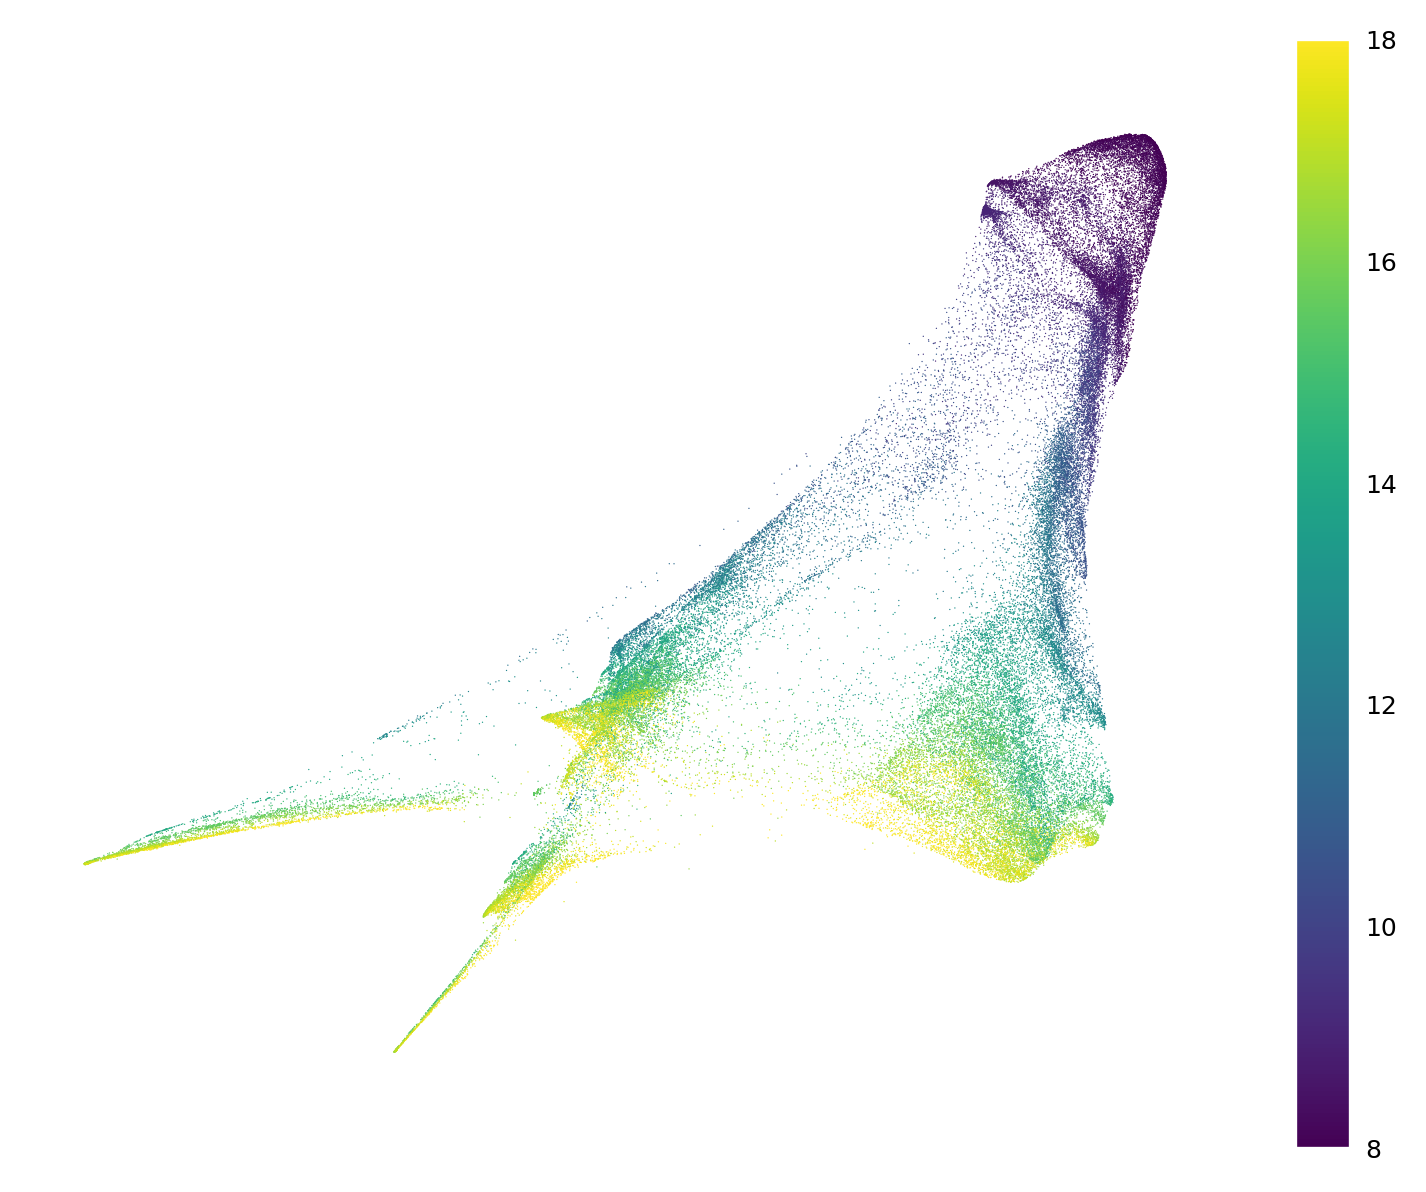

In [24]:
oci.tl.project_2d(adata, x3d_key='X_fa2', output_key='X_proj', alpha=0, beta=45, random_state=SEED)
oci.pl.scatter(adata, x_key='X_proj', color_key='timestamp_float', cmap='viridis', marker_size=0.1)

Lastly, examine topic quality.

(<Figure size 1920x1440 with 21 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>],
        [<AxesSubplot:title={'center':'5'}>,
         <AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'8'}>,
         <AxesSubplot:title={'center':'9'}>],
        [<AxesSubplot:title={'center':'10'}>,
         <AxesSubplot:title={'center':'11'}>,
         <AxesSubplot:title={'center':'12'}>,
         <AxesSubplot:title={'center':'13'}>,
         <AxesSubplot:title={'center':'14'}>],
        [<AxesSubplot:title={'center':'15'}>,
         <AxesSubplot:title={'center':'16'}>,
         <AxesSubplot:title={'center':'17'}>,
         <AxesSubplot:title={'center':'18'}>,
         <AxesSubplot:title={'center':'19'}>]], dtype=object))

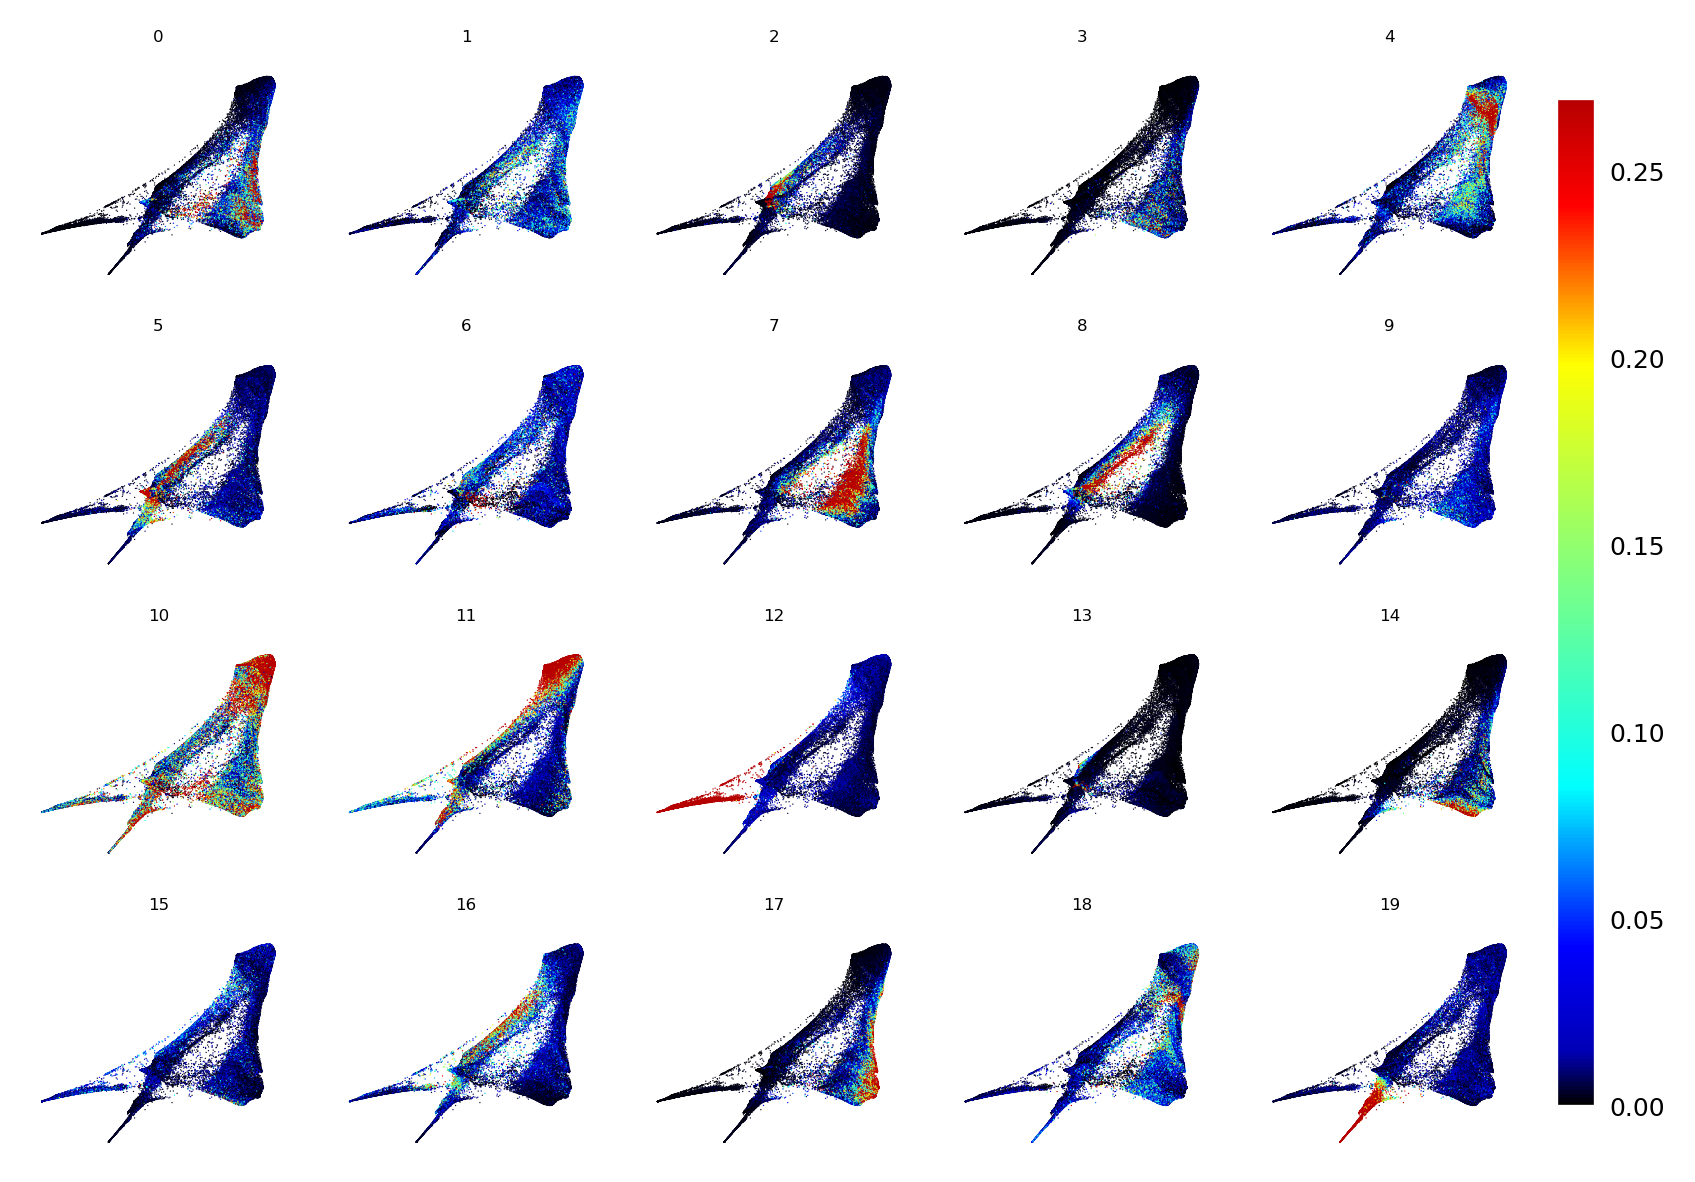

In [25]:
oci.pl.topics(adata, x_key='X_proj', marker_size=0.1)

Congratulations! Now you can easily use Ocelli for your single-cell analyses. Good luck!